In [1]:
! cd ~/loutrebleu/menta/stroker

In [28]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as toptim
import torch.utils as tutils
import torchvision.datasets as tdatasets
import torchvision.transforms as ttransforms
import matplotlib.pyplot as plt

from collections import namedtuple
from IPython.display import clear_output

## Parameters

In [3]:
image_path = "../images/marker/dev1"
batch_size = 32
crop_size = [128, 128]
resize_to = [64, 64]
# clip_size = [112, 112]  # 112=2^4*7  248=2^3*31

## Trial loading

In [126]:
transform = ttransforms.Compose([
    ttransforms.ToTensor()
])

In [127]:
dataset = tdatasets.ImageFolder(image_path, transform)


In [128]:
loader = tutils.data.DataLoader(dataset, batch_size=1, shuffle=False)


In [129]:
sizes = np.vstack([
    [images.shape[2], images.shape[3]]
    for images, _ in loader
])
print("size-max:", sizes.max(axis=0))
print("size-min:", sizes.min(axis=0))


size-max: [1596  490]
size-min: [1181  248]


## Loader

In [4]:
transform = ttransforms.Compose([
    ttransforms.RandomCrop(crop_size),
    ttransforms.Resize(resize_to),
    ttransforms.Grayscale(),
    ttransforms.ToTensor()
])


In [5]:
dataset = tdatasets.ImageFolder(image_path, transform)
loader = tutils.data.DataLoader(tdatasets.ImageFolder(image_path, transform), batch_size=1, shuffle=False)


In [6]:
sizes = np.vstack([
    [images.shape[2], images.shape[3]]
    for images, _ in loader
])
print("size-max:", sizes.max(axis=0))
print("size-min:", sizes.min(axis=0))


size-max: [64 64]
size-min: [64 64]


## Build Network

In [69]:
class ConvBlock(nn.Module):

    def __init__(self, in_channel: int, out_channel: int):
        super().__init__()
        self.cv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.rl1 = nn.ReLU()
        self.cv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.cvs = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=2,)
        self.rl2 = nn.ReLU()
    
    def forward(self, x):
        y = self.cv1(x)
        y = self.bn1(y)
        y = self.rl1(y)
        y = self.cv2(y)
        y = self.bn2(y)
        z = self.cvs(x)
        x = self.rl2(y + z)
        return x

cb1 = ConvBlock(1, 16)
# cb2 = ConvBlock(16, 16)
for images, labels in loader:
    print(images.shape)
    out = cb1(images)
    print(out.shape)
    break


torch.Size([1, 1, 112, 112])
torch.Size([1, 16, 56, 56])


In [70]:
class IdentityBlock(nn.Module):

    def __init__(self, in_channel: int):
        super().__init__()
        self.cv1 = nn.Conv2d(in_channel, in_channel, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channel)
        self.rl1 = nn.ReLU()
        self.cv2 = nn.Conv2d(in_channel, in_channel, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channel)
        self.rl2 = nn.ReLU()
    
    def forward(self, x):
        y = self.cv1(x)
        y = self.bn1(y)
        y = self.rl1(y)
        y = self.cv2(y)
        y = self.bn2(y)
        out = self.rl2(y + x)
        return out
    

cb1 = ConvBlock(1, 16)
cb2 = IdentityBlock(16)
for images, labels in loader:
    print(images.shape)
    feat = cb1(images)
    out = cb2(feat)
    print(out.shape)
    break


torch.Size([1, 1, 112, 112])
torch.Size([1, 16, 56, 56])


### ResNet18
Not Adapted here

In [83]:
class Encoder(nn.Module):

    def __init__(self, in_channel, first_channel=16) -> None:
        super().__init__()

        chs = first_channel * np.asarray([1, 2, 4, 8, 16])

        self.cv0 = nn.Conv2d(in_channel, chs[0], kernel_size=7, stride=2, padding=3)
        self.bn0 = nn.BatchNorm2d(chs[0])
        self.rl0 = nn.ReLU()
        self.mp0 = nn.MaxPool2d(2)

        self.l11 = ConvBlock(chs[0], chs[1])
        self.l12 = IdentityBlock(chs[1])

        self.l21 = ConvBlock(chs[1], chs[2])
        self.l22 = IdentityBlock(chs[2])

        self.l31 = ConvBlock(chs[2], chs[3])
        self.l32 = IdentityBlock(chs[3])

        self.l41 = ConvBlock(chs[3], chs[4])
        self.l42 = IdentityBlock(chs[4])
        
        self.ap5 = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        print("input.shape", x.shape)
        x0 = self.cv0(x)
        x0 = self.bn0(x0)
        x0 = self.rl0(x0)
        x0 = self.mp0(x0)

        x1 = self.l11(x0)
        x1 = self.l12(x1)

        x2 = self.l21(x1)
        x2 = self.l22(x2)

        x3 = self.l31(x2)
        x3 = self.l32(x3)

        x4 = self.l41(x3)
        x4 = self.l42(x4)

        x5 = self.ap5(x4)

        print("in.shape:", x.shape)
        print("x0.shape:", x0.shape)
        print("x1.shape:", x1.shape)
        print("x2.shape:", x2.shape)
        print("x3.shape:", x3.shape)
        print("x4.shape:", x4.shape)
        print("x5.shape", x5.shape)

        return x5

enc = Encoder(1, first_channel=32)
for image, label in loader:
    enc(image)
    break
del enc


input.shape torch.Size([1, 1, 112, 112])
in.shape: torch.Size([1, 1, 112, 112])
x0.shape: torch.Size([1, 32, 28, 28])
x1.shape: torch.Size([1, 64, 14, 14])
x2.shape: torch.Size([1, 128, 7, 7])
x3.shape: torch.Size([1, 256, 4, 4])
x4.shape: torch.Size([1, 512, 2, 2])
x5.shape torch.Size([1, 512, 1, 1])


In [111]:
class BaseConv(nn.Module):

    def __init__(self, in_channel, stride=1) -> None:
        super().__init__()
        out_channel = in_channel * stride
        self.layer1 = self._make_layer(in_channel, stride=stride)
        self.layer2 = self._make_layer(out_channel)
    
    @staticmethod
    def _make_layer(in_channel, stride=1, kernel_size=3):
        out_channel = in_channel * stride
        padding = kernel_size // 2
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        return x2


In [152]:
class EncoderRes(nn.Module):

    def __init__(self, image_size, in_channel, num_cv_layer=4, first_channel=None):
        super().__init__()

        self.image_size = image_size if not hasattr(image_size, "__len__") else image_size[0]
        self.base_channel = in_channel
        self.num_cv_layer = num_cv_layer

        if first_channel is not None:
            self.base_channel = first_channel
        ch = self.base_channel * np.power(2, np.arange(num_cv_layer))

        comp_ratio = 2 ** len(ch)
        cv_out_size = int(image_size / comp_ratio) ** 2 * ch[-1] * 2

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channel, ch[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch[0]),
            nn.ReLU()
        )
        self.layer2 = BaseConv(ch[0], stride=2)
        self.layer3 = BaseConv(ch[1], stride=2)
        self.layer4 = BaseConv(ch[2], stride=2)
        self.layer5 = BaseConv(ch[3], stride=2)
        self.layer6 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(cv_out_size, 100),
            nn.ReLU()
        )
        self.layer_ave = nn.Linear(100, 50)
        self.layer_dev = nn.Linear(100, 50)
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x6 = self.layer6(x5)
        
        ave = self.layer_ave(x6)
        log_dev = self.layer_dev(x6)

        ep = torch.rand_like(ave)
        ft = ave + torch.exp(log_dev / 2) * ep

        return ft, ave, log_dev


enc = EncoderRes(resize_to[0], 1, first_channel=1)
for image, label in loader:
    ret = enc(image)
    print(ret)
    break


(tensor([[ 0.6077,  0.6504,  0.4781,  0.2064,  0.6221,  0.7036,  0.3312,  0.0489,
          0.7043,  0.6507,  0.8411,  1.0515,  0.8484,  1.0058,  0.5329,  0.1488,
          0.1282,  0.4847,  0.5438,  0.7531,  0.0819,  0.0742,  0.5291,  0.1807,
          0.4907,  0.5370,  0.9274,  0.0798,  0.4954,  0.6677,  0.8888,  0.2639,
          0.7793,  0.5099,  0.3169,  0.4428, -0.0791,  0.6734,  0.2242,  0.7376,
         -0.3384,  0.8328,  0.4628,  0.7128,  0.2091,  0.9905,  0.8054,  1.1766,
          0.5125,  0.1294]], grad_fn=<AddBackward0>), tensor([[ 0.0562, -0.1867, -0.0660,  0.1744, -0.3324, -0.0648, -0.1999, -0.3978,
          0.3662,  0.0643, -0.0846,  0.2893,  0.2958,  0.1208, -0.1363,  0.0343,
         -0.0319, -0.1832,  0.0349, -0.0800,  0.0572, -0.0057,  0.4039, -0.2531,
         -0.0757, -0.1809,  0.2421, -0.1815, -0.3462,  0.2613, -0.1179, -0.3781,
         -0.1267, -0.2155, -0.1811, -0.2121, -0.4376, -0.3110, -0.0888,  0.4402,
         -0.4132, -0.0545, -0.3634,  0.0948, -0.3221, 

### Adapted Encoder/Decoder

In [9]:
class Encoder(nn.Module):

    def __init__(self, image_shape, num_layer, base_channel, latent_size=50):
        super().__init__()
        self.image_shape = np.asarray(image_shape)
        self.num_layer = num_layer
        ch = np.power(2, np.arange(num_layer)) * base_channel
        ch = np.insert(ch, 0, image_shape[0])
        self.ch = ch

        self.shape_after_conv = shape_after_conv = (self.image_shape[1:] / (2 ** num_layer) / 2)
        self.size_after_conv = size_after_conv = int(shape_after_conv[0] * shape_after_conv[1] * ch[-1])
        self.latent_size = latent_size

        self.convs = nn.Sequential(*[
            self._make_layer(ich, och)
            for ich, och in zip(ch[:-1], ch[1:])
        ])

        self.layer_flt = nn.Flatten()
        
        self.layer_ave = nn.Sequential(
            nn.Linear(size_after_conv, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size)
        )
        self.layer_dev = nn.Sequential(
            nn.Linear(size_after_conv, 100),
            nn.ReLU(),
            nn.Linear(100, latent_size)
        )
    
    def _make_layer(self, in_ch, out_ch=None):
        out_ch = 2 * in_ch if out_ch is None else out_ch
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
    
    def forward(self, x):
        cvx = self.convs(x)
        cvf = self.layer_flt(cvx)
        
        mean = self.layer_ave(cvf)
        log_dev = self.layer_dev(cvf)

        eps = torch.rand_like(mean)
        feat = mean + torch.exp(log_dev / 2) * eps
        return feat, mean, log_dev



In [10]:
class Decoder(nn.Module):

    def __init__(self, encoder) -> None:
        super().__init__()
        ch = encoder.ch[::-1]
        ch[-1] = ch[-2]
        self.ch = ch

        self.shape_resize_to = np.asarray([ch[0], *encoder.shape_after_conv]).astype(int)
        print(ch)
        print("shape_resize_to:", self.shape_resize_to)

        self.layer_latent = nn.Sequential(
            nn.Linear(encoder.latent_size, 100),
            nn.ReLU(),
            nn.Linear(100, encoder.size_after_conv),
            nn.ReLU()
        )
        self.convs = nn.Sequential(*[
            self._make_layer(ich, och)
            for ich, och in zip(ch[:-1], ch[1:])
        ])
        self.layer_recons = nn.Sequential(
            nn.Conv2d(ch[-1], encoder.image_shape[0], kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def _make_layer(self, in_ch, out_ch=None):
        if out_ch is None:
            out_ch = in_ch // 2
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
    
    def forward(self, x):
        feat = self.layer_latent(x)
        feat = feat.view(x.shape[0], *self.shape_resize_to)
        
        xcv = self.convs(feat)
        recons = self.layer_recons(xcv)

        return recons
    


image_shape = [1, 128, 128]
num_layer = 4
base_channel = 4
enc = Encoder(image_shape, num_layer, base_channel)
dec = Decoder(enc)
for image, label in loader:
    print("image.shape:", image.shape)
    latent, _, _ = enc(image)
    recons = dec(latent)
    
    break


[32 16  8  4  4]
shape_resize_to: [32  4  4]
image.shape: torch.Size([1, 1, 64, 64])


In [23]:
Logger = namedtuple("Logger", "epoch step loss rcloss klloss")

[train] epoch:{3d}  step:{step: 6d}  loss:{epoch_loss: 8.3f}  rcloss:{epoch_rcloss: 8.3f}  klloss:{epoch_klloss: 8.3f}


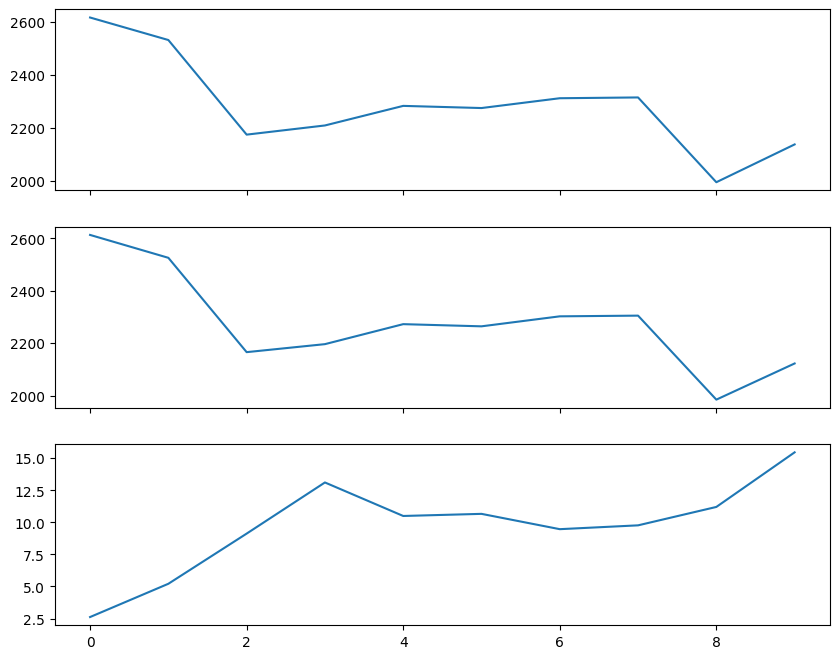

In [30]:
def criterion(predict, target, mean, log_var):
    recons_loss = nn.functional.binary_cross_entropy(predict, target, reduction="sum")
    kl_loss = -1/2 * torch.sum(1 + log_var - mean ** 2 - log_var.exp())
    return recons_loss + kl_loss, recons_loss, kl_loss

image_shape = [1, 128, 128]
num_layer = 4
base_channel = 4
enc = Encoder(image_shape, num_layer, base_channel)
dec = Decoder(enc)

enc_optimizer = toptim.Adam(enc.parameters(), lr=1e-3)
dec_optimizer = toptim.Adam(dec.parameters(), lr=1e-3)

step = 1
logger = Logger([], [], [], [], [])

for epoch in range(10):
    time_avons = time.time()

    epoch_loss = 0
    epoch_rcloss = 0
    epoch_klloss = 0
    
    for image, label in loader:
        latent, mean, log_var = enc(image)
        recons = dec(latent)
        loss, rcloss, klloss = criterion(recons, image, mean, log_var)

        epoch_loss += loss.item() * len(image)
        epoch_rcloss += rcloss.item() * len(image)
        epoch_klloss += klloss.item() * len(image)

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
    
    epoch_loss /= len(dataset)
    epoch_rcloss /= len(dataset)
    epoch_klloss /= len(dataset)

    logger.epoch.append(epoch)
    logger.step.append(step)
    logger.loss.append(epoch_loss)
    logger.rcloss.append(epoch_rcloss)
    logger.klloss.append(epoch_klloss)
 
    clear_output()
    print("[train] epoch:{3d}  step:{step: 6d}  loss:{epoch_loss: 8.3f}  rcloss:{epoch_rcloss: 8.3f}  klloss:{epoch_klloss: 8.3f}")
    fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
    axes[0].plot(logger.epoch, logger.loss)
    axes[1].plot(logger.epoch, logger.rcloss)
    axes[2].plot(logger.epoch, logger.klloss)
    plt.show()
    


In [25]:
len(loader)

52

In [26]:
len(dataset)

52